In [149]:
import requests
import json

import pandas as pd
from pandas.tseries.frequencies import to_offset

import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import time
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

In [150]:
VNINDEX = pd.read_csv("../Dataset/VNINDEX.csv")
VNINDEX

,trunc_time,open_price,high_price,low_price,close_price,volume
0,2017-08-24,766.48,771.65,764.64,769.77,208905050
1,2017-08-25,769.07,771.63,768.57,771.63,218265430
2,2017-08-28,771.81,777.26,770.51,777.26,240572610
3,2017-08-29,773.91,777.11,773.87,774.03,255981300
4,2017-08-30,774.31,778.65,773.85,778.65,193496470
...,...,...,...,...,...,...
1310,2022-11-21,969.33,973.19,956.77,960.65,597720759
1311,2022-11-22,960.65,981.39,948.52,952.12,1050028405
1312,2022-11-23,952.12,958.61,942.02,946.00,542121766
1313,2022-11-24,946.00,950.03,934.31,947.71,543143603


In [151]:
VNINDEX.rename(columns={"trunc_time":"date","open_price":"open","high_price":"high","low_price":"low","close_price":"close"}, inplace= True)
VNINDEX.head(5)

,date,open,high,low,close,volume
0,2017-08-24,766.48,771.65,764.64,769.77,208905050
1,2017-08-25,769.07,771.63,768.57,771.63,218265430
2,2017-08-28,771.81,777.26,770.51,777.26,240572610
3,2017-08-29,773.91,777.11,773.87,774.03,255981300
4,2017-08-30,774.31,778.65,773.85,778.65,193496470


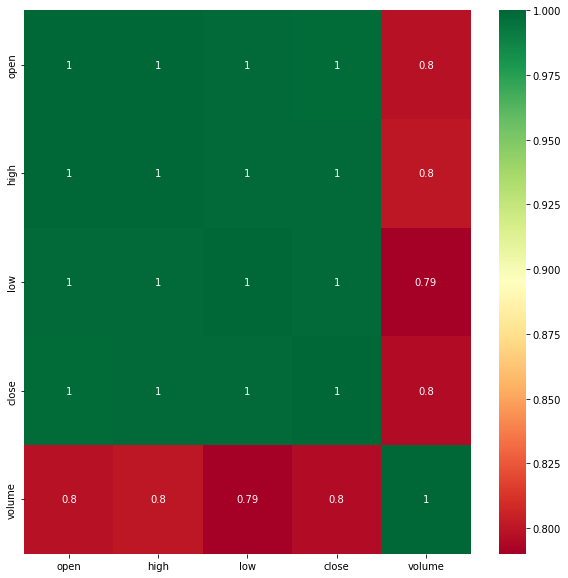

In [152]:
#get correlations of each features in dataset
df = VNINDEX.drop('date', axis=1)
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(VNINDEX[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# PreproceVNINDEXng Data¶

In [153]:
VNINDEX.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [154]:
VNINDEX.isna().any()

date      False
open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [155]:
# VNINDEX.dropna(inplace=True)
# VNINDEX.isna().any()
# no need because VNINDEX dont have any value null or not a number

# Checking datatype of each column¶


In [156]:
# Checking Data type of each column
print("Date column data type: ", type(VNINDEX['date'][0]))
print("Open column data type: ", type(VNINDEX['open'][0]))
print("Close column data type: ", type(VNINDEX['close'][0]))
print("High column data type: ", type(VNINDEX['high'][0]))
print("Low column data type: ", type(VNINDEX['low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>


# Convert date from string to date format


In [157]:
# convert date field from string to Date format and make it index
VNINDEX['date'] = pd.to_datetime(VNINDEX.date)
VNINDEX.head()

,date,open,high,low,close,volume
0,2017-08-24,766.48,771.65,764.64,769.77,208905050
1,2017-08-25,769.07,771.63,768.57,771.63,218265430
2,2017-08-28,771.81,777.26,770.51,777.26,240572610
3,2017-08-29,773.91,777.11,773.87,774.03,255981300
4,2017-08-30,774.31,778.65,773.85,778.65,193496470


. Sorting dataset by date format¶


In [158]:
VNINDEX.sort_values(by='date', inplace=True)
VNINDEX

,date,open,high,low,close,volume
0,2017-08-24,766.48,771.65,764.64,769.77,208905050
1,2017-08-25,769.07,771.63,768.57,771.63,218265430
2,2017-08-28,771.81,777.26,770.51,777.26,240572610
3,2017-08-29,773.91,777.11,773.87,774.03,255981300
4,2017-08-30,774.31,778.65,773.85,778.65,193496470
...,...,...,...,...,...,...
1310,2022-11-21,969.33,973.19,956.77,960.65,597720759
1311,2022-11-22,960.65,981.39,948.52,952.12,1050028405
1312,2022-11-23,952.12,958.61,942.02,946.00,542121766
1313,2022-11-24,946.00,950.03,934.31,947.71,543143603


In [159]:
VNINDEX.shape

(1315, 6)

# EDA - Exploratory Data Analysis



Get the duration of dataset


In [160]:
print("Starting date: ",VNINDEX.iloc[0][0])
print("Ending date: ", VNINDEX.iloc[-1][0])
print("Duration: ", VNINDEX.iloc[-1][0]-VNINDEX.iloc[0][0])

Starting date:  2017-08-24 00:00:00
Ending date:  2022-11-25 00:00:00
Duration:  1919 days 00:00:00


Monthwise comparision between Stock actual, open and close price


In [161]:
monthvise= VNINDEX.groupby(VNINDEX['date'].dt.strftime('%B'))[['open','close']].mean().sort_values(by='close')
monthvise

,open,close
date,,
October,1019.715606,1018.940076
September,1039.493417,1038.582583
November,1038.586220,1038.777638
July,1046.682883,1046.338468
May,1067.732692,1068.639135
August,1067.207350,1068.815983
December,1082.306147,1082.169817
June,1087.777196,1087.954112
January,1107.439592,1107.940204


In [162]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock actual, open and close price')
fig.show()

Monthwise High and Low stock price


In [163]:
VNINDEX.groupby(VNINDEX['date'].dt.strftime('%B'))['low'].min()


date
April        657.41
August       764.64
December     882.17
February     872.46
January      861.85
July         779.82
June         821.92
March        649.10
May          760.04
November     831.58
October      795.05
September    784.18
Name: low, dtype: float64

In [164]:
monthvise_high= VNINDEX.groupby(VNINDEX['date'].dt.strftime('%B'))['high'].max()
monthvise_low= VNINDEX.groupby(VNINDEX['date'].dt.strftime('%B'))['low'].min()

In [165]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

Trend comparision between stock price, open price, close price, high price, low price¶


In [166]:
from itertools import cycle
import plotly.express as px

names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(VNINDEX, x=VNINDEX.date, y=[VNINDEX['open'], VNINDEX['close'], 
                                          VNINDEX['high'], VNINDEX['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Close price prediction preparation and preproceVNINDEXng¶



Make separate dataframe with close price


In [54]:
closedf = VNINDEX[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1720, 2)


Plotting stock close price chart


In [55]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.6)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Normalizing / scaling close value between 0 to 1


In [56]:
close_stock = closedf.copy()
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1720, 1)


Split data for training and testing


In [57]:
training_size=int(len(closedf)*0.8)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1376, 1)
test_data:  (344, 1)


Create new dataset according to requirement of time-series prediction


In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1355, 20)
y_train:  (1355,)
X_test:  (323, 20)
y_test (323,)


# RF

In [60]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100,random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [61]:
# Lets Do the prediction 

RF_train_predict=regressor.predict(X_train)
RF_test_predict=regressor.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
RF_train_predict = RF_train_predict.reshape(-1,1)
RF_test_predict = RF_test_predict.reshape(-1,1)

print("Train data prediction:", RF_train_predict.shape)
print("Test data prediction:", RF_test_predict.shape)

Train data prediction: (1355, 1)
Test data prediction: (323, 1)


In [62]:
# Transform back to original form

RF_train_predict = scaler.inverse_transform(RF_train_predict)
RF_test_predict = scaler.inverse_transform(RF_test_predict)
RF_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
RF_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [63]:
# Evaluation metrices RMSE and MAE
RF_RMSE_train = math.sqrt(mean_squared_error(RF_original_ytrain,RF_train_predict))
RF_MSE_train = mean_squared_error(RF_original_ytrain,RF_train_predict)
RF_MAE_train = mean_absolute_error(RF_original_ytrain,RF_train_predict)

RF_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,RF_test_predict))
RF_MSE_test = mean_squared_error(RF_original_ytest,RF_test_predict)
RF_MAE_test = mean_absolute_error(RF_original_ytest,RF_test_predict)

print("Train data RMSE: ", RF_RMSE_train)
print("Train data MSE: ", RF_MSE_train)
print("Test data MAE: ", RF_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", RF_RMSE_test)
print("Test data MSE: ", RF_MSE_test)
print("Test data MAE: ", RF_MAE_test)

Train data RMSE:  65.06809711365949
Train data MSE:  4233.857261992623
Test data MAE:  45.11092250922509
-------------------------------------------------------------------------------------
Test data RMSE:  2251.3751712528415
Test data MSE:  5068690.1617337605
Test data MAE:  1554.8235294117671


Explained variance regreVNINDEXon score
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [64]:
RF_EV_train = explained_variance_score(RF_original_ytrain, RF_train_predict)
RF_EV_test = explained_variance_score(RF_original_ytest, RF_test_predict)

print("Train data explained variance regreVNINDEXon score:", RF_EV_train)
print("Test data explained variance regreVNINDEXon score:", RF_EV_test)

Train data explained variance regression score: 0.9983747147785555
Test data explained variance regression score: 0.6757581049016752


R2 score for regreVNINDEXon
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regreVNINDEXon model.

1 = Best
0 or < 0 = worse

In [65]:
RF_r2_train = r2_score(RF_original_ytrain, RF_train_predict)
RF_r2_test = r2_score(RF_original_ytest, RF_test_predict)

print("Train data R2 score:", RF_r2_train)
print("Test data R2 score:", RF_r2_test)

Train data R2 score: 0.9983745855659447
Test data R2 score: 0.4444553215315561


RegreVNINDEXon Loss Mean Gamma deviance regreVNINDEXon loss (MGD) and Mean Poisson deviance regreVNINDEXon loss (MPD)¶


In [66]:
RF_MGD_train = mean_gamma_deviance(RF_original_ytrain, RF_train_predict)
RF_MGD_test = mean_gamma_deviance(RF_original_ytest, RF_test_predict)
RF_MPD_train = mean_poisson_deviance(RF_original_ytrain, RF_train_predict)
RF_MPD_test = mean_poisson_deviance(RF_original_ytest, RF_test_predict)
print("Train data MGD: ", RF_MGD_train)
print("Test data MGD: ", RF_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", RF_MPD_train)
print("Test data MPD: ",RF_MPD_test)

Train data MGD:  0.00011161830932915249
Test data MGD:  0.045866758565015944
----------------------------------------------------------------------
Train data MPD:  0.6629753976569311
Test data MPD:  479.89985597431985


Comparision between original stock close price vs predicted close price¶


In [67]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(RF_train_predict)+look_back, :] = RF_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(RF_train_predict)+(look_back*2)+1:len(closedf)-1, :] = RF_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1720, 1)
Test predicted data:  (1720, 1)


# Predicting next 10 days


In [68]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


Plotting last 15 days and next predicted 10 days


In [69]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[21 22 23 24 25 26 27 28 29 30]


In [70]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting whole closing stock price with prediction¶


In [71]:
rfdf=closedf.tolist()
rfdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rfdf=scaler.inverse_transform(rfdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RF + Optuna

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import optuna

# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['poisson', 'squared_error', 'absolute_error', 'friedman_mse'])
    random_state = 42

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=random_state
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Optuna: ", best_params)

regressor_optuna = RandomForestRegressor(**best_params)
regressor_optuna.fit(X_train, y_train)

[I 2023-05-07 17:10:38,723] A new study created in memory with name: no-name-bf29a143-6d5c-4147-9281-58accb4e7f12
[W 2023-05-07 17:10:43,072] Trial 0 failed with parameters: {'n_estimators': 294, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'bootstrap': True, 'criterion': 'squared_error'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ACER\AppData\Local\Temp\ipykernel_3492\2769239681.py", line 28, in objective
    model.fit(X_train, y_train)
  File "c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Python310\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Python310\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
 

In [ ]:
# Lets Do the prediction 

OP_train_predict=regressor_optuna.predict(X_train)
OP_test_predict=regressor_optuna.predict(X_test)

OP_train_predict = OP_train_predict.reshape(-1,1)
OP_test_predict = OP_test_predict.reshape(-1,1)

print("Train data prediction:", OP_train_predict.shape)
print("Test data prediction:", OP_test_predict.shape)

In [ ]:
# Transform back to original form

OP_train_predict = scaler.inverse_transform(OP_train_predict)
OP_test_predict = scaler.inverse_transform(OP_test_predict)
OP_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
OP_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
OP_RMSE_train = math.sqrt(mean_squared_error(OP_original_ytrain,OP_train_predict))
OP_MSE_train = mean_squared_error(OP_original_ytrain,RF_train_predict)
OP_MAE_train = mean_absolute_error(OP_original_ytrain,OP_train_predict)
OP_RMSE_test = math.sqrt(mean_squared_error(RF_original_ytest,OP_test_predict))
OP_MSE_test = mean_squared_error(OP_original_ytest,OP_test_predict)
OP_MAE_test = mean_absolute_error(OP_original_ytest,OP_test_predict)

print("Train data RMSE: ", OP_RMSE_train)
print("Train data MSE: ", OP_MSE_train)
print("Test data MAE: ", OP_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", OP_RMSE_test)
print("Test data MSE: ", OP_MSE_test)
print("Test data MAE: ", OP_MAE_test)

In [ ]:
OP_EV_train = explained_variance_score(OP_original_ytrain, OP_train_predict)
OP_EV_test = explained_variance_score(OP_original_ytest, OP_test_predict)

print("Train data explained variance regreVNINDEXon score:", OP_EV_train)
print("Test data explained variance regreVNINDEXon score:", OP_EV_test)

In [ ]:
OP_r2_train = r2_score(OP_original_ytrain, OP_train_predict)
OP_r2_test = r2_score(OP_original_ytest, OP_test_predict)

print("Train data R2 score:", OP_r2_train)
print("Test data R2 score:", OP_r2_test)

In [ ]:
OP_MGD_train = mean_gamma_deviance(OP_original_ytrain, OP_train_predict)
OP_MGD_test = mean_gamma_deviance(OP_original_ytest, OP_test_predict)
OP_MPD_train = mean_poisson_deviance(OP_original_ytrain, OP_train_predict)
OP_MPD_test = mean_poisson_deviance(OP_original_ytest, OP_test_predict)
print("Train data MGD: ", OP_MGD_train)
print("Test data MGD: ", OP_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", OP_MPD_train)
print("Test data MPD: ",OP_MPD_test)

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(OP_train_predict)+look_back, :] = OP_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(OP_train_predict)+(look_back*2)+1:len(closedf)-1, :] = OP_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor_optuna.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor_optuna.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
opdf=closedf.tolist()
opdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
opdf=scaler.inverse_transform(opdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rfdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RF Bayes Optimization

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer

# # Load the stock price data
# df = pd.read_csv('stock_price_data.csv')

# # Split the data into features and target variable
# X = df.drop('target', axis=1)
# y = df['target']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function to minimize
def objective(params):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Define the search space for hyperparameters
space = [Integer(10, 1000, name='n_estimators'),
         Integer(1, 50, name='max_depth'),
         Integer(2, 20, name='min_samples_split'),
         Integer(1, 20, name='min_samples_leaf'),
         Real(0.1, 1.0, prior='uniform', name='max_features')]

# Run Bayesian optimization to find the best hyperparameters
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Print the best hyperparameters and corresponding mean squared error
print("Best hyperparameters:", result.x)
print("Best mean squared error:", result.fun)

# Train a new random forest regressor with the best hyperparameters
clf = RandomForestRegressor(n_estimators=result.x[0], max_depth=result.x[1],
                             min_samples_split=result.x[2], min_samples_leaf=result.x[3],
                             max_features=result.x[4], random_state=42)
clf.fit(X_train, y_train)

# # Use the trained model to predict future stock prices
# future_dates = pd.date_range(start='2023-04-14', end='2024-04-14', freq='D')
# future_X = pd.DataFrame({'date': future_dates})
# future_X['day_of_week'] = future_X['date'].dt.dayofweek
# future_X['month'] = future_X['date'].dt.month
# future_X['day_of_month'] = future_X['date'].dt.day
# future_X['year'] = future_X['date'].dt.year
# future_X = future_X.drop('date', axis=1)
# future_y = clf.predict(future_X)


In [ ]:
# Lets Do the prediction 

BY_train_predict=clf.predict(X_train)
BY_test_predict=clf.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
BY_train_predict = BY_train_predict.reshape(-1,1)
BY_test_predict = BY_test_predict.reshape(-1,1)

print("Train data prediction:", RF_train_predict.shape)
print("Test data prediction:", RF_test_predict.shape)

In [ ]:
# Transform back to original form

BY_train_predict = scaler.inverse_transform(BY_train_predict)
BY_test_predict = scaler.inverse_transform(BY_test_predict)
BY_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
BY_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
BY_RMSE_train = math.sqrt(mean_squared_error(BY_original_ytrain,BY_train_predict))
BY_MSE_train = mean_squared_error(BY_original_ytrain,BY_train_predict)
BY_MAE_train = mean_absolute_error(BY_original_ytrain,BY_train_predict)

BY_RMSE_test = math.sqrt(mean_squared_error(BY_original_ytest,BY_test_predict))
BY_MSE_test = mean_squared_error(BY_original_ytest,BY_test_predict)
BY_MAE_test = mean_absolute_error(BY_original_ytest,BY_test_predict)

print("Train data RMSE: ", BY_RMSE_train)
print("Train data MSE: ", BY_MSE_train)
print("Test data MAE: ", BY_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", BY_RMSE_test)
print("Test data MSE: ", BY_MSE_test)
print("Test data MAE: ", BY_MAE_test)

In [ ]:
BY_EV_train = explained_variance_score(BY_original_ytrain, BY_train_predict)
BY_EV_test = explained_variance_score(BY_original_ytest, BY_test_predict)

print("Train data explained variance regreVNINDEXon score:", BY_EV_train)
print("Test data explained variance regreVNINDEXon score:", BY_EV_test)

In [ ]:
BY_r2_train = r2_score(BY_original_ytrain, BY_train_predict)
BY_r2_test = r2_score(BY_original_ytest, BY_test_predict)

print("Train data R2 score:", BY_r2_train)
print("Test data R2 score:", BY_r2_test)

In [ ]:
BY_MGD_train = mean_gamma_deviance(BY_original_ytrain, BY_train_predict)
BY_MGD_test = mean_gamma_deviance(BY_original_ytest, BY_test_predict)
BY_MPD_train = mean_poisson_deviance(BY_original_ytrain, BY_train_predict)
BY_MPD_test = mean_poisson_deviance(BY_original_ytest, BY_test_predict)
print("Train data MGD: ", BY_MGD_train)
print("Test data MGD: ", BY_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", BY_MPD_train)
print("Test data MPD: ",BY_MPD_test)

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(BY_train_predict)+look_back, :] = BY_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(RF_train_predict)+(look_back*2)+1:len(closedf)-1, :] = RF_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = clf.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = clf.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
bydf=closedf.tolist()
bydf.extend((np.array(lst_output).reshape(-1,1)).tolist())
bydf=scaler.inverse_transform(bydf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(bydf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# RandomizedSearchCV + RF 

In [ ]:
regressor1 = RandomForestRegressor(random_state = 0)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
rfc_cv = RandomizedSearchCV(estimator = regressor1,  param_distributions = params_grid, verbose = 0, cv = 5, n_iter = 100,n_jobs=-1)

In [ ]:
rfc_cv.fit(X_train, y_train)

In [ ]:
print(f'best: {rfc_cv.best_params_}')


In [ ]:
regressor1 = RandomForestRegressor(**rfc_cv.best_params_)

In [ ]:
regressor1.fit(X_train, y_train)

In [ ]:
# Lets Do the prediction 

rf_cv_train_predict=regressor1.predict(X_train)
rf_cv_test_predict=regressor1.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
rf_cv_train_predict = rf_cv_train_predict.reshape(-1,1)
rf_cv_test_predict = rf_cv_test_predict.reshape(-1,1)

print("Train data prediction:", rf_cv_train_predict.shape)
print("Test data prediction:", rf_cv_test_predict.shape)

In [ ]:
# Transform back to original form

rf_cv_train_predict = scaler.inverse_transform(rf_cv_train_predict)
rf_cv_test_predict = scaler.inverse_transform(rf_cv_test_predict)
rf_cv_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
rf_cv_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
rf_cv_RMSE_train = math.sqrt(mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict))
rf_cv_MSE_train = mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict)
rf_cv_MAE_train = mean_absolute_error(rf_cv_original_ytrain,rf_cv_train_predict)

rf_cv_RMSE_test = math.sqrt(mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict))
rf_cv_MSE_test = mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict)
rf_cv_MAE_test = mean_absolute_error(rf_cv_original_ytest,rf_cv_test_predict)

print("Train data RMSE: ", math.sqrt(mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict)))
print("Train data MSE: ", mean_squared_error(rf_cv_original_ytrain,rf_cv_train_predict))
print("Test data MAE: ", mean_absolute_error(rf_cv_original_ytrain,rf_cv_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict)))
print("Test data MSE: ", mean_squared_error(rf_cv_original_ytest,rf_cv_test_predict))
print("Test data MAE: ", mean_absolute_error(rf_cv_original_ytest,rf_cv_test_predict))

In [ ]:
rf_cv_EV_train = explained_variance_score(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_EV_test = explained_variance_score(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data explained variance regreVNINDEXon score:", explained_variance_score(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data explained variance regreVNINDEXon score:", explained_variance_score(rf_cv_original_ytest, rf_cv_test_predict))

In [ ]:
rf_cv_r2_train = r2_score(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_r2_test = r2_score(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data R2 score:", r2_score(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data R2 score:", r2_score(rf_cv_original_ytest, rf_cv_test_predict))

In [ ]:
rf_cv_MGD_train = mean_gamma_deviance(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_MGD_test = mean_gamma_deviance(rf_cv_original_ytest, rf_cv_test_predict)
rf_cv_MPD_train = mean_poisson_deviance(rf_cv_original_ytrain, rf_cv_train_predict)
rf_cv_MPD_test = mean_poisson_deviance(rf_cv_original_ytest, rf_cv_test_predict)

print("Train data MGD: ", mean_gamma_deviance(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data MGD: ", mean_gamma_deviance(rf_cv_original_ytest, rf_cv_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(rf_cv_original_ytrain, rf_cv_train_predict))
print("Test data MPD: ", mean_poisson_deviance(rf_cv_original_ytest, rf_cv_test_predict))

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(rf_cv_train_predict)+look_back, :] = rf_cv_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(rf_cv_train_predict)+(look_back*2)+1:len(closedf)-1, :] = rf_cv_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = regressor1.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = regressor1.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
rf_cvdf=closedf.tolist()
rf_cvdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
rf_cvdf=scaler.inverse_transform(rf_cvdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(rf_cvdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Extra Tree (Random Forest extension)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor


In [ ]:
et = ExtraTreesRegressor(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 4, max_features = 'auto', max_depth = 60, bootstrap = True, random_state = 0)


In [ ]:
et.fit(X_train, y_train)


In [ ]:
# Lets Do the prediction 

et_train_predict=et.predict(X_train)
et_test_predict=et.predict(X_test)
# print("Train data prediction:", train_predict)
# # print("Test data prediction:", test_predict)
et_train_predict = et_train_predict.reshape(-1,1)
et_test_predict = et_test_predict.reshape(-1,1)

print("Train data prediction:", et_train_predict.shape)
print("Test data prediction:", et_test_predict.shape)

In [ ]:
# Transform back to original form

et_train_predict = scaler.inverse_transform(et_train_predict)
et_test_predict = scaler.inverse_transform(et_test_predict)
et_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
et_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
# Evaluation metrices RMSE and MAE
et_RMSE_train = math.sqrt(mean_squared_error(et_original_ytrain,et_train_predict))
et_MSE_train = mean_squared_error(et_original_ytrain,et_train_predict)
et_MAE_train = mean_absolute_error(et_original_ytrain,et_train_predict)

et_RMSE_test = math.sqrt(mean_squared_error(et_original_ytest,et_test_predict))
et_MSE_test = mean_squared_error(et_original_ytest,et_test_predict)
et_MAE_test = mean_absolute_error(et_original_ytest,et_test_predict)

print("Train data RMSE: ", math.sqrt(mean_squared_error(et_original_ytrain,et_train_predict)))
print("Train data MSE: ", mean_squared_error(et_original_ytrain,et_train_predict))
print("Test data MAE: ", mean_absolute_error(et_original_ytrain,et_train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(et_original_ytest,et_test_predict)))
print("Test data MSE: ", mean_squared_error(et_original_ytest,et_test_predict))
print("Test data MAE: ", mean_absolute_error(et_original_ytest,et_test_predict))

In [ ]:
et_EV_train = explained_variance_score(et_original_ytrain, et_train_predict)
et_EV_test = explained_variance_score(et_original_ytest, et_test_predict)

print("Train data explained variance regreVNINDEXon score:", explained_variance_score(et_original_ytrain, et_train_predict))
print("Test data explained variance regreVNINDEXon score:", explained_variance_score(et_original_ytest,et_test_predict))

In [ ]:
et_r2_train = r2_score(et_original_ytrain, et_train_predict)
et_r2_test = r2_score(et_original_ytest, et_test_predict)

print("Train data R2 score:", r2_score(et_original_ytrain, et_train_predict))
print("Test data R2 score:", r2_score(et_original_ytest, et_test_predict))

In [ ]:
et_MGD_train = mean_gamma_deviance(et_original_ytrain, et_train_predict)
et_MGD_test = mean_gamma_deviance(et_original_ytest, et_test_predict)
et_MPD_train = mean_poisson_deviance(et_original_ytrain, et_train_predict)
et_MPD_test = mean_poisson_deviance(et_original_ytest, et_test_predict)

print("Train data MGD: ", mean_gamma_deviance(et_original_ytrain, et_train_predict))
print("Test data MGD: ", mean_gamma_deviance(et_original_ytest, et_test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(et_original_ytrain, et_train_predict))
print("Test data MPD: ", mean_poisson_deviance(et_original_ytest, et_test_predict))

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(et_train_predict)+look_back, :] = et_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(et_train_predict)+(look_back*2)+1:len(closedf)-1, :] = et_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = et.predict(x_input)
#         print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = et.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)
names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
etdf=closedf.tolist()
etdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
etdf=scaler.inverse_transform(etdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(etdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# KNN 

In [ ]:
from sklearn import neighbors

K = time_step
neighbor = neighbors.KNeighborsRegressor(n_neighbors = 5)
neighbor.fit(X_train, y_train)

In [ ]:
# Lets Do the prediction 

KNN_train_predict=neighbor.predict(X_train)
KNN_test_predict=neighbor.predict(X_test)

KNN_train_predict = KNN_train_predict.reshape(-1,1)
KNN_test_predict = KNN_test_predict.reshape(-1,1)

print("Train data prediction:", KNN_train_predict.shape)
print("Test data prediction:", KNN_test_predict.shape)

In [ ]:
# Transform back to original form

KNN_train_predict = scaler.inverse_transform(KNN_train_predict)
KNN_test_predict = scaler.inverse_transform(KNN_test_predict)
KNN_original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
KNN_original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Evaluation metrices RMSE, MSE and MAE
Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
# Evaluation metrices RMSE and MAE
KNN_RMSE_train = math.sqrt(mean_squared_error(KNN_original_ytrain,KNN_train_predict))
KNN_MSE_train = mean_squared_error(KNN_original_ytrain,KNN_train_predict)
KNN_MAE_train = mean_absolute_error(KNN_original_ytrain,KNN_train_predict)

KNN_RMSE_test = math.sqrt(mean_squared_error(KNN_original_ytest,KNN_test_predict))
KNN_MSE_test = mean_squared_error(KNN_original_ytest,KNN_test_predict)
KNN_MAE_test = mean_absolute_error(KNN_original_ytest,KNN_test_predict)

print("Train data RMSE: ", KNN_RMSE_train)
print("Train data MSE: ", KNN_MSE_train)
print("Test data MAE: ", KNN_MAE_train)
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", KNN_RMSE_test)
print("Test data MSE: ", KNN_MSE_test)
print("Test data MAE: ", KNN_MAE_test)

Explained variance regreVNINDEXon score
The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
KNN_EV_train = explained_variance_score(KNN_original_ytrain, KNN_train_predict)
KNN_EV_test = explained_variance_score(KNN_original_ytest, KNN_test_predict)

print("Train data explained variance regreVNINDEXon score:", KNN_EV_train)
print("Test data explained variance regreVNINDEXon score:", KNN_EV_test)

R2 score for regreVNINDEXon
R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regreVNINDEXon model.

1 = Best
0 or < 0 = worse

In [ ]:
KNN_r2_train = r2_score(KNN_original_ytrain, KNN_train_predict)
KNN_r2_test = r2_score(KNN_original_ytest, KNN_test_predict)

print("Train data R2 score:", KNN_r2_train)
print("Test data R2 score:", KNN_r2_test)

# RegreVNINDEXon Loss Mean Gamma deviance regreVNINDEXon loss (MGD) and Mean Poisson deviance regreVNINDEXon loss (MPD)¶


In [ ]:
KNN_MGD_train = mean_gamma_deviance(KNN_original_ytrain, KNN_train_predict)
KNN_MGD_test = mean_gamma_deviance(KNN_original_ytest, KNN_test_predict)
KNN_MPD_train = mean_poisson_deviance(KNN_original_ytrain, KNN_train_predict)
KNN_MPD_test = mean_poisson_deviance(KNN_original_ytest, KNN_test_predict)
print("Train data MGD: ", KNN_MGD_train)
print("Test data MGD: ", KNN_MGD_test)
print("----------------------------------------------------------------------")
print("Train data MPD: ", KNN_MPD_train)
print("Test data MPD: ",KNN_MPD_test)

Comparision between original stock close price vs predicted close price


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(KNN_train_predict)+look_back, :] = KNN_train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(KNN_train_predict)+(look_back*2)+1:len(closedf)-1, :] = KNN_test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Predicting next 10 days¶


In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = neighbor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = neighbor.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Plotting last 15 days and next predicted 10 days¶


In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
import copy

temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = copy.deepcopy(temp_mat)
next_predicted_days_value = copy.deepcopy(temp_mat)

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
last_original_days_value.append(None)

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 10 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Plotting whole closing stock price with prediction


In [ ]:
knndf=closedf.tolist()
knndf.extend((np.array(lst_output).reshape(-1,1)).tolist())
knndf=scaler.inverse_transform(knndf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(knndf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# finaldf = pd.DataFrame({
#     'rf':rfdf,
#     'knn':knndf,
#     'rf_cv':rf_cvdf,
#     'et': etdf,
# })
# finaldf.tail()

In [ ]:
# names = cycle([ 'RF','KNN','RF_CV','ET'])

# fig = px.line(finaldf[225:], x=finaldf.index[225:], y=[finaldf['rf'][225:], finaldf['knn'][225:], finaldf['rf_cv'][225:],finaldf['et'][225:]],
#              labels={'x': 'Timestamp','value':'Stock close price'})
# fig.update_layout(title_text='Final stock analysis chart', font_size=15, font_color='black',legend_title_text='Algorithms')
# fig.for_each_trace(lambda t:  t.update(name = next(names)))
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)

# fig.show()

In [ ]:
# EM_train = {'Random Forest':["{:.4f}".format(RF_RMSE_train),"{:.4f}".format(RF_MSE_train),"{:.4f}".format(RF_MAE_train),
#                        "{:.4f}".format(RF_EV_train),
#                        "{:.4f}".format(RF_r2_train),
#                        "{:.4f}".format(RF_MGD_train),
#                        "{:.4f}".format(RF_MPD_train)],
#       'KNN':["{:.4f}".format(KNN_RMSE_train),"{:.4f}".format(KNN_MSE_train),"{:.4f}".format(KNN_MAE_train),
#                       "{:.4f}".format(KNN_EV_train),
#                        "{:.4f}".format(KNN_r2_train),
#                        "{:.4f}".format(KNN_MGD_train),
#                        "{:.4f}".format(KNN_MPD_train)],
#             'RF + RandomizedSearchCV':["{:.4f}".format(rf_cv_RMSE_train),"{:.4f}".format(rf_cv_MSE_train),"{:.4f}".format(rf_cv_MAE_train),
#                        "{:.4f}".format(rf_cv_EV_train),
#                        "{:.4f}".format(rf_cv_r2_train),
#                        "{:.4f}".format(rf_cv_MGD_train),
#                        "{:.4f}".format(rf_cv_MPD_train)],
#                  'ET':["{:.4f}".format(et_RMSE_train),"{:.4f}".format(et_MSE_train),"{:.4f}".format(et_MAE_train),
#                       "{:.4f}".format(et_EV_train),
#                        "{:.4f}".format(et_r2_train),
#                        "{:.4f}".format(et_MGD_train),
#                        "{:.4f}".format(et_MPD_train)]}
# EM_test = {'Random Forest':["{:.4f}".format(RF_RMSE_test),"{:.4f}".format(RF_MSE_test),"{:.4f}".format(RF_MAE_test),
#                        "{:.4f}".format(RF_EV_test),
#                        "{:.4f}".format(RF_r2_test),
#                        "{:.4f}".format(RF_MGD_test),
#                        "{:.4f}".format(RF_MPD_test)],
#       'KNN':["{:.4f}".format(KNN_RMSE_test),"{:.4f}".format(KNN_MSE_test),"{:.4f}".format(KNN_MAE_test),
#                       "{:.4f}".format(KNN_EV_test),
#                        "{:.4f}".format(KNN_r2_test),
#                        "{:.4f}".format(KNN_MGD_test),
#                        "{:.4f}".format(KNN_MPD_test)],
#           'RF + RandomizedSearchCV':["{:.4f}".format(rf_cv_RMSE_test),"{:.4f}".format(rf_cv_MSE_test),"{:.4f}".format(rf_cv_MAE_test),
#                        "{:.4f}".format(rf_cv_EV_test),
#                        "{:.4f}".format(rf_cv_r2_test),
#                        "{:.4f}".format(rf_cv_MGD_test),
#                        "{:.4f}".format(rf_cv_MPD_test)],      
#            'ET':["{:.4f}".format(et_RMSE_test),"{:.4f}".format(et_MSE_test),"{:.4f}".format(et_MAE_test),
#                       "{:.4f}".format(et_EV_test),
#                        "{:.4f}".format(et_r2_test),
#                        "{:.4f}".format(et_MGD_test),
#                        "{:.4f}".format(et_MPD_test)]}
# EM_comparision_train = pd.DataFrame(EM_train,index=['RMSE','MSE','MAE','Explained variance regreVNINDEXon score','R2 score','MGD','MPD'])
# EM_comparision_test = pd.DataFrame(EM_test,index=['RMSE','MSE','MAE','Explained variance regreVNINDEXon score','R2 score','MGD','MPD'])

# print((EM_comparision_train))
# print('--------------------------------------------------------------------------------------------------')
# print(format(EM_comparision_test))